In [1]:
using LinearAlgebra
using DifferentialEquations:ODEProblem, solve, EnsembleProblem, EnsembleSummary
using StaticArrays
using Plots
using Base.Threads
using ElectronSpinDynamics:sample_from_sphere, sphere_to_cartesian

In [2]:
A1 = [SMatrix{3, 3}([1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])]
A2 = [SMatrix{3, 3}([1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0])]
C = SMatrix{3, 3}([0.4 0.0 0.0; 0.0 0.4 0.0; 0.0 0.0 0.8])
ω1 = SVector{3}([0.0; 0.0; 1.0])
ω2 = SVector{3}([0.0; 0.0; 1.0])

3-element SVector{3, Float64} with indices SOneTo(3):
 0.0
 0.0
 1.0

In [3]:
θ, ϕ = sample_from_sphere((4,1))
ux, uy, uz = sphere_to_cartesian(θ, ϕ)
S1 = [ux[1]; uy[1]; uz[1]] * √3/2
S2 = [ux[2]; uy[2]; uz[2]] * √3/2
I1 = [ux[3]; uy[3]; uz[3]] * √3/2
I2 = [ux[4]; uy[4]; uz[4]] * √3/2
u0 = reduce(hcat, [S1, S2, I1, I2])

3×4 Matrix{Float64}:
 -0.101841   0.385438   0.32092    0.510068
  0.08817   -0.479183  -0.282945   0.133361
  0.855485  -0.609771   0.752962  -0.687056

In [4]:
function prob_func(prob, i, repeat)
    θ, ϕ = sample_from_sphere((4,1))
    ux, uy, uz = sphere_to_cartesian(θ, ϕ)
    S1 = [ux[1]; uy[1]; uz[1]] * √3/2
    S2 = [ux[2]; uy[2]; uz[2]] * √3/2
    I1 = [ux[3]; uy[3]; uz[3]] * √3/2
    I2 = [ux[4]; uy[4]; uz[4]] * √3/2
    newu0 = reduce(hcat, (S1, S2, I1, I2))   # no @., no broadcasting
    prob.u0 .= newu0
    return prob# return a fresh problem
end

prob_func (generic function with 1 method)

In [5]:
function SC1!(du, u, p, t)
    S1 = u[:, 1]
    S2 = u[:, 2]
    N1 = length(A1)
    N2 = length(A2)
    du[:, 1] = cross(ω1 + C*S2 + sum(A1[k]*u[:, 2+k] for k in 1:N1), S1)
    du[:, 2] = cross(ω2 + C*S1 + sum(A2[k]*u[:, 2+N1+k] for k in 1:N2), S2)
    for k in 1:N1
        du[:, 2+k] = cross(A1[k]' * S1, u[:, 2+k])
    end
    for k in 1:N2
        du[:, 2+k+N1] = cross(A2[k]' * S2, u[:, 2+k+N1])
    end
end

SC1! (generic function with 1 method)

In [6]:
dt = 0.05
saveat = 0.0:dt:1.0
tspan = (0.0, last(saveat))

(0.0, 1.0)

In [7]:
prob = ODEProblem(SC1!, u0, tspan)

ODEProblem with uType Matrix{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 1.0)
u0: 3×4 Matrix{Float64}:
 -0.101841   0.385438   0.32092    0.510068
  0.08817   -0.479183  -0.282945   0.133361
  0.855485  -0.609771   0.752962  -0.687056

In [8]:
sol = solve(prob, dt=dt, saveat=saveat)

retcode: Success
Interpolation: 1st order linear
t: 21-element Vector{Float64}:
 0.0
 0.05
 0.1
 0.15
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 0.5
 0.55
 0.6
 0.65
 0.7
 0.75
 0.8
 0.85
 0.9
 0.95
 1.0
u: 21-element Vector{Matrix{Float64}}:
 [-0.10184144049382392 0.3854383632029636 0.32092049153483865 0.5100675673076688; 0.08816998730681272 -0.47918312723714396 -0.28294544726826354 0.13336127844406606; 0.8554848767432767 -0.6097711035648141 0.7529620919961374 -0.6870559265391727]
 [-0.12614198017836503 0.40365231499943666 0.33543260690575966 0.5298492900770743; 0.06018714695764004 -0.44473016729657466 -0.26460442609884394 0.13072889530083134; 0.8546728661673764 -0.6239229815372677 0.7533056908764086 -0.6724356368710901]
 [-0.1471380542545228 0.4207250008635406 0.348018203993952 0.5481195622499409; 0.02999855631616886 -0.40847450486540465 -0.24484763644282195 0.12744150802173132; 0.8529070867424339 -0.6372904148350478 0.7542764585168638 -0.6582731917888227]
 [-0.1646353954366 0.436566117112101

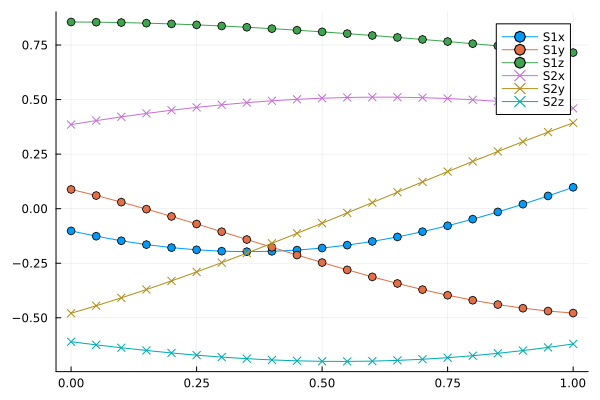

In [9]:
plot(sol.t, [sol.u[i][1, 1] for i in 1:size(sol.t)[1]], label="S1x", marker=:o)
plot!(sol.t, [sol.u[i][2, 1] for i in 1:size(sol.t)[1]], label="S1y", marker=:o)
plot!(sol.t, [sol.u[i][3, 1] for i in 1:size(sol.t)[1]], label="S1z", marker=:o)
plot!(sol.t, [sol.u[i][1, 2] for i in 1:size(sol.t)[1]], label="S2x", marker=:x)
plot!(sol.t, [sol.u[i][2, 2] for i in 1:size(sol.t)[1]], label="S2y", marker=:x)
plot!(sol.t, [sol.u[i][3, 2] for i in 1:size(sol.t)[1]], label="S2z", marker=:x)

In [10]:
output_func(sol, i) = (sol, false)
function output_func(sol, i)
    t = sol.t
    N = length(t)
    corr_S = Array{Float64, 4}(undef, N, 2, 3, 3)
    corr_T0 = Array{Float64, 4}(undef, N, 2, 3, 3)
    S0 = sol.u[1]
    for k in 1:N
        Sk = sol.u[k]
        for i in 1:2
            S0i = S0[:, i]
            Ski = Sk[:, i]
            for α in 1:3
                Skiα = Ski[α]
                sign = α ≤ 2 && i == 1 ? +1 : -1
                for β in 1:3
                    S0iβ = S0i[β]
                    corr_S[k, i, α, β] = Skiα * S0iβ
                    corr_T0[k, i, α, β] = Skiα * S0iβ * (-sign)
                end
            end
        end
    end
    Ps = 1 / 4 .+ sum(prod(corr_S, dims=2) .* 4.0, dims=(3,4))[:, 1, 1, 1]
    Pt0 = 1 / 4 .+ sum(prod(corr_T0, dims=2) .* 4.0, dims=(3,4))[:, 1, 1, 1]
    
    Ptp = ones(Float64, N) * 1/4
    Ptm = ones(Float64, N) * 1/4

    for k in 1:N
        Sk = sol.u[k]
        S01 = S0[:, 1]
        S02 = S0[:, 2]
        Sk1 = Sk[:, 1]
        Sk2 = Sk[:, 2]

        S01x = S01[1]
        S02x = S02[1]
        S01y = S01[2]
        S02y = S02[2]
        S01z = S01[3]
        S02z = S02[3]
        
        Sk1z = Sk1[3]
        Sk2z = Sk2[3]

        Ptp[k] -= (4.0*Sk1z*Sk2z + 2.0*Sk1z + 2.0*Sk2z)* (S01x*S02x + S01y*S02y + S01z*S02z) 
        Ptm[k] -= (4.0*Sk1z*Sk2z - 2.0*Sk1z - 2.0*Sk2z)* (S01x*S02x + S01y*S02y + S01z*S02z) 
    end

    ((t, Ptp, Pt0, Ps, Ptm), false)
end
eprob = EnsembleProblem(prob, output_func=output_func, prob_func=prob_func)

EnsembleProblem with problem ODEProblem

In [11]:
data = solve(eprob, dt=dt, saveat=saveat, trajectories=100_000)
@show data[1][1]
@show data[1][2]

(data[1])[1] = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
(data[1])[2] = [0.9944063398801773, 0.9869107457597122, 0.9868734039044781, 0.9944567527910201, 1.0097430166582142, 1.0327246639758236, 1.0632924558995467, 1.1012283114346415, 1.1461985021171814, 1.1977462223596738, 1.255293544845207, 1.3181466974209202, 1.3854949946562105, 1.456424861856647, 1.52993701007626, 1.6049694609442295, 1.68040686281703, 1.7551073500244403, 1.8279336247791644, 1.8977774177057336, 1.963583148951543]


21-element Vector{Float64}:
 0.9944063398801773
 0.9869107457597122
 0.9868734039044781
 0.9944567527910201
 1.0097430166582142
 1.0327246639758236
 1.0632924558995467
 1.1012283114346415
 1.1461985021171814
 1.1977462223596738
 1.255293544845207
 1.3181466974209202
 1.3854949946562105
 1.456424861856647
 1.52993701007626
 1.6049694609442295
 1.68040686281703
 1.7551073500244403
 1.8279336247791644
 1.8977774177057336
 1.963583148951543

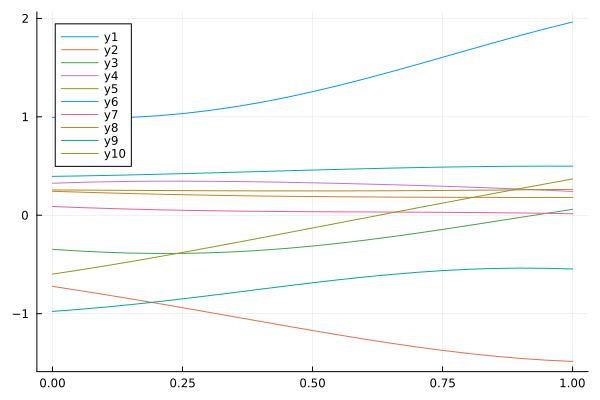

In [12]:
plot(data[1][1], data[1][2])
for i in 2:10
    plot!(data[i][1], data[i][2])
end
plot!()

Ps_avg = [[0.9998097134592111, 0.9989385679874969, 0.9961470710234965, 0.991458507775701, 0.9849123836698273, 0.9765637325106886, 0.9664820767134994, 0.954750973935306, 0.9414666413972677, 0.9267362848289075, 0.91067696918311, 0.8934141521103285, 0.8750797878064215, 0.8558106058011903, 0.8357465925337476, 0.8150293074242745, 0.7938000842402306, 0.7721984161836447, 0.7503606259158769, 0.7284185444148877, 0.7064983332150421]]


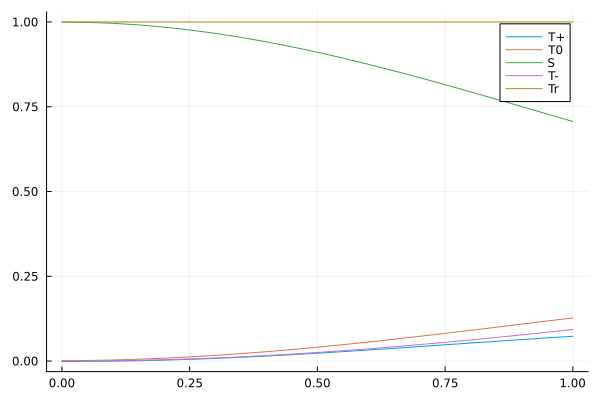

In [13]:
N = length(data)
Ptp_avg = sum([data[k][2] for k in 1:N], dims=1) / length(data)
Pt0_avg = sum([data[k][3] for k in 1:N], dims=1) / length(data)
Ps_avg = sum([data[k][4] for k in 1:N], dims=1) / length(data)
Ptm_avg = sum([data[k][5] for k in 1:N], dims=1) / length(data)
@show Ps_avg
plot(data[1][1], Ptp_avg, label="T+")
plot!(data[1][1], Pt0_avg, label="T0")
plot!(data[1][1], Ps_avg, label="S")
plot!(data[1][1], Ptm_avg, label="T-")
plot!(data[1][1],  Ptp_avg + Pt0_avg +Ps_avg +Ptm_avg, label="Tr")